# Assignment 2 - Machine Learning
**Project:** Project 1 - Classify Images of Road Traffic Signs

**Group Name:** Dan & Ethan
| Name               | Student Number |
|--------------------|----------------|
| Daniel Schellekens | s3900792       |
| Ethan Rayner       | s3902240       |

## Holdout Validation
In this exercise, holdout validation will be used. A random 20% split of the data is test aside to perform validation against.

In [1]:
IMAGES_FILE = "images.csv"
TEST_TRAIN_SPLIT = 0.2
IMAGE_SIZE = 28

from models.utils import prep_data

data, train_data, val_data = prep_data(IMAGES_FILE, TEST_TRAIN_SPLIT)
data.head()

Training set: 2959 rows
Validation set: 740 rows


,path,shape,type
0,images\diamond\rightofway\00032_00000.png,diamond,rightofway
1,images\diamond\rightofway\00032_00001.png,diamond,rightofway
2,images\diamond\rightofway\00032_00002.png,diamond,rightofway
3,images\diamond\rightofway\00037_00000.png,diamond,rightofway
4,images\diamond\rightofway\00037_00001.png,diamond,rightofway


## Exploratory Data Analysis
The following graphs demonstrate that both classes appear correctly in the dataset. It also shows there is major imbalance in the representation for each class. There are very few images of stop signs, which not only has an impact on the type class, but results in there being very few signs of the "hex" shape.

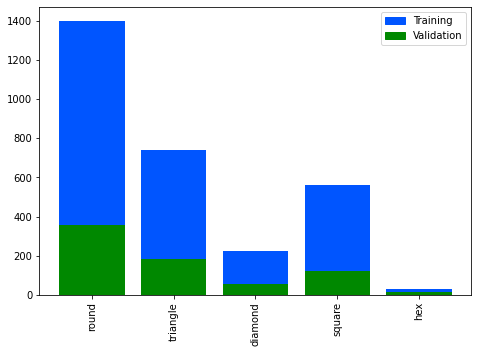

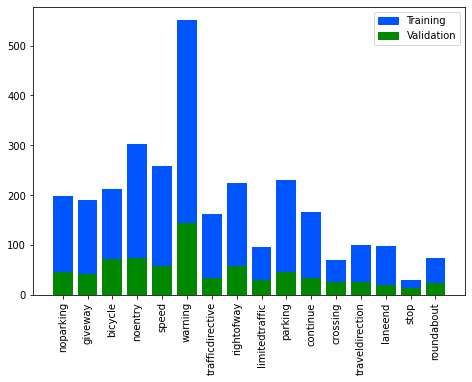

In [2]:
from models.eda import classes_histogram

classes_histogram(train_data, val_data, "shape")
classes_histogram(train_data, val_data, "type")

## Performance Metric
Due to the large class imbalance (as seen above), accuracy does not make for a good performance metric, as the model could completely ignore stop signs and still perform quite well. A good alternative for accuracy is the F1-Score. F1-Scores are calculated for each class independently, using formulas based on the number of true positives, false positives and false negatives, the overall F1-Score is the mean of the F1-Scores for each class. This means each class has equal weighting, so a model that does poorly on stop signs will incur the same penalty as one that does poorly on warning signs. 

## Training the Model
ImageDataGenerators are used to generate training and validation images that aren't always identical to the originals in the `images/` directory. A series of random translations, scaling, rotations and brightness shifts are applied to the images first. This ensures that as the model trains during the numerous epochs, it is seeing somewhat fresh data not repeated information that it could overfit to.

### Model 2 - AlexNet

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


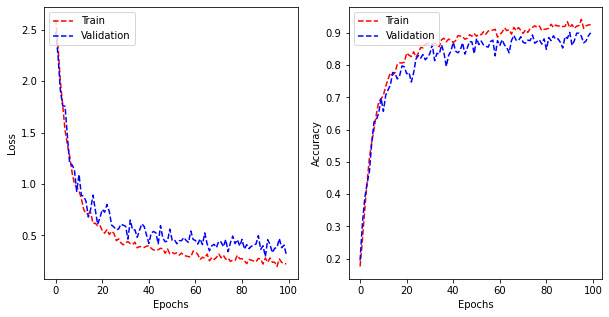

In [3]:
CLASS_COLUMN = "type"
BATCH_SIZE = 32
EPOCHS = 100

import models.alexnet as alex
from models.utils import history_graph
from models.utils import create_generator

alex_train_images = create_generator(train_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
alex_val_images = create_generator(val_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
alex_model, alex_history = alex.fit_model(data, CLASS_COLUMN, alex_train_images, alex_val_images, IMAGE_SIZE, EPOCHS)
history_graph(alex_history)

### Model 3 - Modified VGGNet


Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


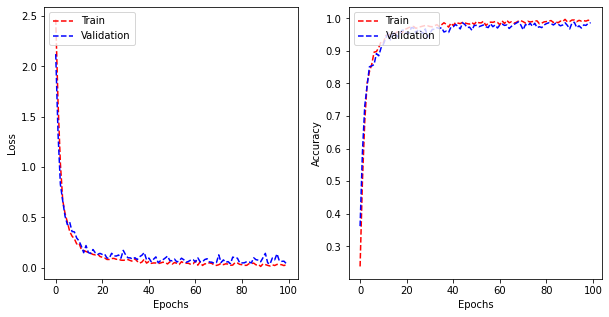

In [4]:
CLASS_COLUMN = "type"
BATCH_SIZE = 32
EPOCHS = 100

import models.vggnet as vgg
from models.utils import history_graph
from models.utils import create_generator

vgg_train_images = create_generator(train_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
vgg_val_images = create_generator(val_data, CLASS_COLUMN, IMAGE_SIZE, BATCH_SIZE)
vgg_model, vgg_history = vgg.fit_model(data, CLASS_COLUMN, vgg_train_images, vgg_val_images, IMAGE_SIZE, EPOCHS)
history_graph(vgg_history)

## Independent Evaluation
The final results are determined from an independent dataset of 80 images (5 of each class) sourced from Street Imagery made available by KartaView under a Creative Commons Attribution-ShareAlike 4.0 International ([https://kartaview.org/terms](https://kartaview.org/terms)). These images have been pre-processed to match the 28x28 dimensions and greyscale colors of the original dataset. This tests the performance of the model on unseen "real-world" data.

Found 80 validated image filenames belonging to 16 classes.
F1 Scores (per class):
    bicycle:             38.7
    continue:            82.2
    crossing:            87.7
    giveway:             100.0
    laneend:             54.5
    limitedtraffic:      32.4
    noentry:             92.8
    noparking:           72.5
    parking:             77.4
    rightofway:          91.5
    roundabout:          76.4
    speed:               55.2
    stop:                52.9
    trafficdirective:    19.7
    traveldirection:     35.9
Mean F1 score: 66.3
Found 80 validated image filenames belonging to 16 classes.
F1 Scores (per class):
    bicycle:             100.0
    continue:            100.0
    crossing:            90.6
    giveway:             100.0
    laneend:             100.0
    limitedtraffic:      72.7
    noentry:             100.0
    noparking:           90.0
    parking:             91.2
    rightofway:          82.2
    roundabout:          88.5
    speed:               74.

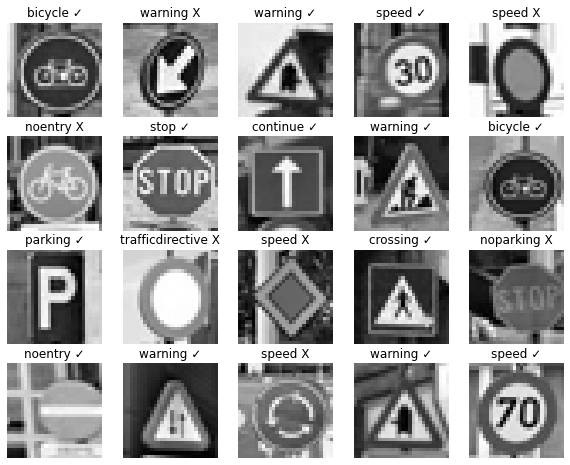

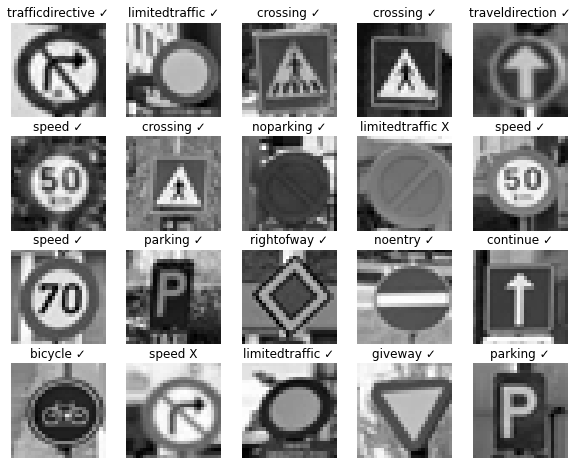

In [5]:
NUM_TO_VISUALIZE = 20
NUM_TO_SCORE = 500
IMAGES_FILE = "test-images.csv"

from models.test import create_test_generator
from models.test import show_visual_results
from models.test import print_f1_scores

alex_test_images = create_test_generator(IMAGES_FILE, CLASS_COLUMN, IMAGE_SIZE, 1)
show_visual_results(alex_model, alex_test_images, NUM_TO_VISUALIZE)
print_f1_scores(alex_model, alex_test_images, NUM_TO_SCORE)

vgg_test_images = create_test_generator(IMAGES_FILE, CLASS_COLUMN, IMAGE_SIZE, 1)
show_visual_results(vgg_model, vgg_test_images, NUM_TO_VISUALIZE)
print_f1_scores(vgg_model, vgg_test_images, NUM_TO_SCORE)